<a href="https://colab.research.google.com/github/Atharvaahirrao/Practical/blob/main/Copy_of_Untitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dagster dagster-webserver yfinance pandas numpy scikit-learn matplotlib seaborn


In [ ]:
import os
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from dagster import asset, Failure, materialize

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error


In [ ]:
from dagster import asset, Failure
import pandas as pd
import os

@asset
def stock_data():
    cache_file = "aapl_stock.csv"

    # 1️⃣ Use cached data if already downloaded
    if os.path.exists(cache_file):
        print("✅ Using cached stock data")
        return pd.read_csv(cache_file)

    # 2️⃣ Try Yahoo Finance ONCE
    print("⬇️ Trying to download from Yahoo Finance...")
    data = yf.download(
        "AAPL",
        start="2019-01-01",
        end="2024-01-01",
        progress=False
    )

    # 3️⃣ If Yahoo fails, use backup data
    if data.empty:
        print("⚠️ Yahoo blocked request. Using backup dataset.")

        backup_data = {
            "Date": pd.date_range(start="2019-01-01", periods=200),
            "Close": np.random.normal(150, 10, 200),
            "Open": np.random.normal(149, 10, 200),
            "High": np.random.normal(151, 10, 200),
            "Low": np.random.normal(148, 10, 200),
            "Volume": np.random.randint(1e6, 5e6, 200)
        }

        df = pd.DataFrame(backup_data)
        df.to_csv(cache_file, index=False)
        return df

    # 4️⃣ Save Yahoo data if successful
    data.reset_index(inplace=True)
    data.to_csv(cache_file, index=False)
    return data



In [ ]:
@asset
def eda(stock_data: pd.DataFrame):
    plt.figure(figsize=(10,4))
    sns.lineplot(x="Date", y="Close", data=stock_data)
    plt.title("Apple Stock Closing Price")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()
    return "EDA completed"


In [ ]:
@asset
def features(stock_data: pd.DataFrame):
    df = stock_data.copy()

    df["Returns"] = df["Close"].pct_change()
    df["MA_10"] = df["Close"].rolling(10).mean()
    df["MA_50"] = df["Close"].rolling(50).mean()

    df.dropna(inplace=True)

    if df.empty:
        raise Failure("Feature engineering produced empty dataset")

    return df


In [ ]:
@asset
def train_test_data(features: pd.DataFrame):
    if features.empty:
        raise Failure("Features dataset is empty")

    X = features[["Returns", "MA_10", "MA_50"]]
    y = features["Close"]

    return train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
@asset
def decision_tree(train_test_data):
    X_train, X_test, y_train, y_test = train_test_data

    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)

    print("Decision Tree MSE:", mse)
    return mse


In [ ]:
@asset
def random_forest(train_test_data):
    X_train, X_test, y_train, y_test = train_test_data

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)

    print("Random Forest MSE:", mse)
    return mse


In [ ]:
@asset
def gradient_boost(train_test_data):
    X_train, X_test, y_train, y_test = train_test_data

    model = GradientBoostingRegressor(random_state=42)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)

    print("Gradient Boosting MSE:", mse)
    return mse


2026-01-21 14:48:15 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 22d71f94-0ad1-4973-bb95-6f147d8c151a - 669 - RUN_START - Started execution of run for "__ephemeral_asset_job__".
2026-01-21 14:48:15 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 22d71f94-0ad1-4973-bb95-6f147d8c151a - 669 - ENGINE_EVENT - Executing steps in process (pid: 669)
2026-01-21 14:48:15 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 22d71f94-0ad1-4973-bb95-6f147d8c151a - 669 - RESOURCE_INIT_STARTED - Starting initialization of resources [io_manager].
2026-01-21 14:48:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 22d71f94-0ad1-4973-bb95-6f147d8c151a - 669 - RESOURCE_INIT_SUCCESS - Finished initialization of resources [io_manager].
2026-01-21 14:48:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 22d71f94-0ad1-4973-bb95-6f147d8c151a - 669 - LOGS_CAPTURED - Started capturing logs in process (pid: 669).
2026-01-21 14:48:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 22d71f94-0

⬇️ Trying to download from Yahoo Finance...
⚠️ Yahoo blocked request. Using backup dataset.


2026-01-21 14:48:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 22d71f94-0ad1-4973-bb95-6f147d8c151a - 669 - eda - STEP_START - Started execution of step "eda".
2026-01-21 14:48:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 22d71f94-0ad1-4973-bb95-6f147d8c151a - eda - Loading file from: /tmp/tmplwp0t_8e/storage/stock_data using PickledObjectFilesystemIOManager...
2026-01-21 14:48:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 22d71f94-0ad1-4973-bb95-6f147d8c151a - 669 - eda - LOADED_INPUT - Loaded input "stock_data" using input manager "io_manager", from output "result" of step "stock_data"
2026-01-21 14:48:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 22d71f94-0ad1-4973-bb95-6f147d8c151a - 669 - eda - STEP_INPUT - Got input "stock_data" of type "DataFrame". (Type check passed).


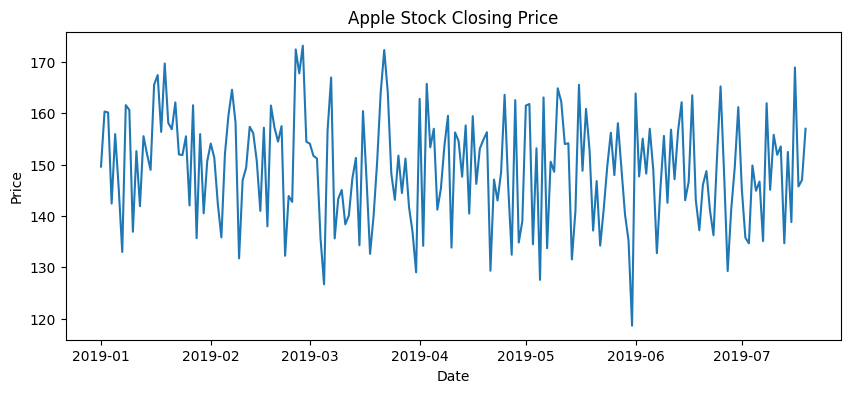

2026-01-21 14:48:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 22d71f94-0ad1-4973-bb95-6f147d8c151a - 669 - eda - STEP_OUTPUT - Yielded output "result" of type "Any". (Type check passed).
2026-01-21 14:48:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 22d71f94-0ad1-4973-bb95-6f147d8c151a - eda - Writing file at: /tmp/tmplwp0t_8e/storage/eda using PickledObjectFilesystemIOManager...
2026-01-21 14:48:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 22d71f94-0ad1-4973-bb95-6f147d8c151a - 669 - eda - ASSET_MATERIALIZATION - Materialized value eda.
2026-01-21 14:48:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 22d71f94-0ad1-4973-bb95-6f147d8c151a - 669 - eda - HANDLED_OUTPUT - Handled output "result" using IO manager "io_manager"
2026-01-21 14:48:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 22d71f94-0ad1-4973-bb95-6f147d8c151a - 669 - eda - STEP_SUCCESS - Finished execution of step "eda" in 555ms.
2026-01-21 14:48:16 +0000 - dagster - DEBUG - __ephe

Decision Tree MSE: 125.65272570759014


2026-01-21 14:48:17 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 22d71f94-0ad1-4973-bb95-6f147d8c151a - 669 - gradient_boost - STEP_OUTPUT - Yielded output "result" of type "Any". (Type check passed).
2026-01-21 14:48:17 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 22d71f94-0ad1-4973-bb95-6f147d8c151a - gradient_boost - Writing file at: /tmp/tmplwp0t_8e/storage/gradient_boost using PickledObjectFilesystemIOManager...
2026-01-21 14:48:17 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 22d71f94-0ad1-4973-bb95-6f147d8c151a - 669 - gradient_boost - ASSET_MATERIALIZATION - Materialized value gradient_boost.
2026-01-21 14:48:17 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 22d71f94-0ad1-4973-bb95-6f147d8c151a - 669 - gradient_boost - HANDLED_OUTPUT - Handled output "result" using IO manager "io_manager"
2026-01-21 14:48:17 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 22d71f94-0ad1-4973-bb95-6f147d8c151a - 669 - gradient_boost - STEP_SUCCESS - Finished execution

Gradient Boosting MSE: 73.98078099613387


2026-01-21 14:48:17 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 22d71f94-0ad1-4973-bb95-6f147d8c151a - 669 - random_forest - STEP_OUTPUT - Yielded output "result" of type "Any". (Type check passed).
2026-01-21 14:48:17 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 22d71f94-0ad1-4973-bb95-6f147d8c151a - random_forest - Writing file at: /tmp/tmplwp0t_8e/storage/random_forest using PickledObjectFilesystemIOManager...
2026-01-21 14:48:17 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 22d71f94-0ad1-4973-bb95-6f147d8c151a - 669 - random_forest - ASSET_MATERIALIZATION - Materialized value random_forest.
2026-01-21 14:48:17 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 22d71f94-0ad1-4973-bb95-6f147d8c151a - 669 - random_forest - HANDLED_OUTPUT - Handled output "result" using IO manager "io_manager"
2026-01-21 14:48:17 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 22d71f94-0ad1-4973-bb95-6f147d8c151a - 669 - random_forest - STEP_SUCCESS - Finished execution of ste

Random Forest MSE: 70.65506722935575


In [ ]:
materialize([
    stock_data,
    eda,
    features,
    train_test_data,
    decision_tree,
    random_forest,
    gradient_boost
])


In [ ]:
materialize([
    stock_data,
    features,
    train_test_data,
    decision_tree,
    random_forest,
    gradient_boost
])


2026-01-21 14:49:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 8c0ece6f-b0b3-4160-a01c-2e3d36d8b884 - 669 - RUN_START - Started execution of run for "__ephemeral_asset_job__".
2026-01-21 14:49:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 8c0ece6f-b0b3-4160-a01c-2e3d36d8b884 - 669 - ENGINE_EVENT - Executing steps in process (pid: 669)
2026-01-21 14:49:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 8c0ece6f-b0b3-4160-a01c-2e3d36d8b884 - 669 - RESOURCE_INIT_STARTED - Starting initialization of resources [io_manager].
2026-01-21 14:49:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 8c0ece6f-b0b3-4160-a01c-2e3d36d8b884 - 669 - RESOURCE_INIT_SUCCESS - Finished initialization of resources [io_manager].
2026-01-21 14:49:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 8c0ece6f-b0b3-4160-a01c-2e3d36d8b884 - 669 - LOGS_CAPTURED - Started capturing logs in process (pid: 669).
2026-01-21 14:49:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 8c0ece6f-b

✅ Using cached stock data


2026-01-21 14:49:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 8c0ece6f-b0b3-4160-a01c-2e3d36d8b884 - features - Writing file at: /tmp/tmpzi_jtx40/storage/features using PickledObjectFilesystemIOManager...
2026-01-21 14:49:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 8c0ece6f-b0b3-4160-a01c-2e3d36d8b884 - 669 - features - ASSET_MATERIALIZATION - Materialized value features.
2026-01-21 14:49:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 8c0ece6f-b0b3-4160-a01c-2e3d36d8b884 - 669 - features - HANDLED_OUTPUT - Handled output "result" using IO manager "io_manager"
2026-01-21 14:49:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 8c0ece6f-b0b3-4160-a01c-2e3d36d8b884 - 669 - features - STEP_SUCCESS - Finished execution of step "features" in 150ms.
2026-01-21 14:49:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 8c0ece6f-b0b3-4160-a01c-2e3d36d8b884 - 669 - train_test_data - STEP_START - Started execution of step "train_test_data".
2026-01-21 14:49:16 +

Decision Tree MSE: 125.65272570759015


2026-01-21 14:49:17 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 8c0ece6f-b0b3-4160-a01c-2e3d36d8b884 - 669 - gradient_boost - STEP_OUTPUT - Yielded output "result" of type "Any". (Type check passed).
2026-01-21 14:49:17 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 8c0ece6f-b0b3-4160-a01c-2e3d36d8b884 - gradient_boost - Writing file at: /tmp/tmpzi_jtx40/storage/gradient_boost using PickledObjectFilesystemIOManager...
2026-01-21 14:49:17 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 8c0ece6f-b0b3-4160-a01c-2e3d36d8b884 - 669 - gradient_boost - ASSET_MATERIALIZATION - Materialized value gradient_boost.
2026-01-21 14:49:17 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 8c0ece6f-b0b3-4160-a01c-2e3d36d8b884 - 669 - gradient_boost - HANDLED_OUTPUT - Handled output "result" using IO manager "io_manager"
2026-01-21 14:49:17 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 8c0ece6f-b0b3-4160-a01c-2e3d36d8b884 - 669 - gradient_boost - STEP_SUCCESS - Finished execution

Gradient Boosting MSE: 73.98078099613386


2026-01-21 14:49:18 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 8c0ece6f-b0b3-4160-a01c-2e3d36d8b884 - 669 - random_forest - STEP_OUTPUT - Yielded output "result" of type "Any". (Type check passed).
2026-01-21 14:49:18 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 8c0ece6f-b0b3-4160-a01c-2e3d36d8b884 - random_forest - Writing file at: /tmp/tmpzi_jtx40/storage/random_forest using PickledObjectFilesystemIOManager...
2026-01-21 14:49:18 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 8c0ece6f-b0b3-4160-a01c-2e3d36d8b884 - 669 - random_forest - ASSET_MATERIALIZATION - Materialized value random_forest.
2026-01-21 14:49:18 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 8c0ece6f-b0b3-4160-a01c-2e3d36d8b884 - 669 - random_forest - HANDLED_OUTPUT - Handled output "result" using IO manager "io_manager"
2026-01-21 14:49:18 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 8c0ece6f-b0b3-4160-a01c-2e3d36d8b884 - 669 - random_forest - STEP_SUCCESS - Finished execution of ste

Random Forest MSE: 70.62240149096421
